# Creating a Kaggle Workflow

In this guided project, we're going to put together all that we've learned and create a data science workflow, using a pipleline of functions to reduce the number of dimensions we need to focus on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
holdout.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


## Processing the data

we have created functions to preprocess the data, and now we can put them togother.

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
# put the above functions together to preprocess data
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ['Age_categories','Fare_categories','Title','Cabin_type','Sex']:
        df = create_dummies(df,col)
    return df

In [7]:
train = pre_process(train)
holdout = pre_process(holdout)

## Exploring the Data

The Kaggle workflow we are going to build will combine the following four steps into a process:

- Data exploration, to find patterns in the data
- Feature engineering, to create new features from those patterns or through pure experimentation
- Feature selection, to select the best subset of our current set of features
- Model selection/tuning, training a number of models with different hyperparameters to find the best performer.

For now, we are going to examine two columns that contains information about the family members each passenger had onboard: 'SibSp' and 'Parch'.

In [8]:
# Inspect the type of the columns 
train[['SibSp','Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


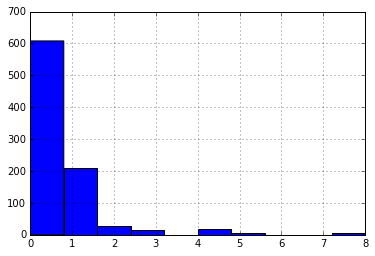

In [9]:
# histogram of "SibSp" column
train['SibSp'].hist()

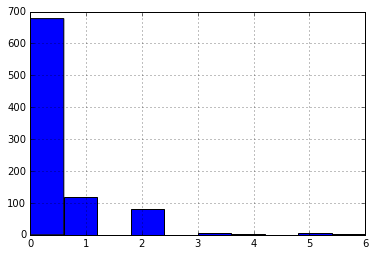

In [10]:
# histogram of "Parch" column
train['Parch'].hist()

In [11]:
# pivot table of "SibSp" column
pd.pivot_table(data = train, index = 'SibSp',values = 'Survived')

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


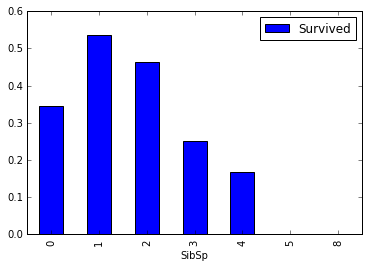

In [12]:
# plot pivot table of "SibSp" column
pd.pivot_table(data = train, index = 'SibSp',values = 'Survived').plot.bar()

In [13]:
# pivot table of "Parch" column
pd.pivot_table(data = train, index = 'Parch',values = 'Survived')

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


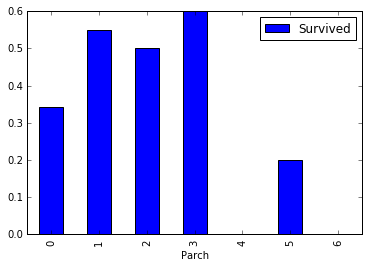

In [14]:
# plot of pivot table of "Parch" column
pd.pivot_table(data = train, index = 'Parch',values = 'Survived').plot.bar()

        Survived
Family          
0       0.303538
1       0.552795
2       0.578431
3       0.724138
4       0.200000
5       0.136364
6       0.333333
7       0.000000
10      0.000000


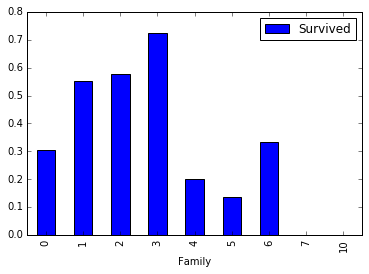

In [15]:
# Find a way to combine the two columns and look at the resulting distribution of values and survival rate.
df = train[['SibSp','Parch','Survived']].copy()
df['Family'] = df['SibSp'] + df['Parch']
print(pd.pivot_table(data = df, index = 'Family',values = 'Survived'))
pd.pivot_table(data = df, index = 'Family',values = 'Survived').plot.bar()

## Engineering New Features

We notice that among all the survived only 30% had no family members onboard. Based on this, we can create a new feature- was the passenger alone.

In [16]:
# create "islone" column based on "SibSp" and "Parch" column
def create_isalone(df):
    df['isalone'] = 0
    isalone = ((df['SibSp']== 0) & (df['Parch'] ==0))
    df.loc[isalone,'isalone']=1
    return df
train = create_isalone(train)
holdout = create_isalone(holdout)

## Selecting the Best-Performing Features

To speed up our Kaggle workflow, we can create a function that performs feature selection step. And we can focus our efforts on the more createive part - exploring data and engineering new features.

Let's write a function that:
- accepts a dataframe as input
- performs data preparation for machine learning
- uses recursive features elimination and the random forests algorithm to find the best-performing set of features

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [18]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis = 1)
    all_X = df.drop(['PassengerId', 'Survived'], axis = 1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state = 1)
    selector = RFECV(rf, cv = 10)
    selector.fit(all_X, all_y)
    best_columns = list(all_X.columns[selector.support_])
    print(best_columns)
    return best_columns

In [19]:
best_columns = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Selecting and Tuning Different Algorithms

We can write a function to do the heavy lifting of model selection and tuning like we did with feature select. The function we'll create will use three different algorithms and use grid search to train using different combimations of hyperparameters to find the best performing model.



In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs","liblinear"]
            }
            
        },
        {
            "name": "KNeighborsClassifier",
             "estimator": KNeighborsClassifier(),
             "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
             }           
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
            {
                "n_estimators":[4,6,9],
                "criterion":["entropy","gini"],
                "max_depth":[2,5,10],
                "max_features":["log2","sqrt"],
                "min_samples_leaf":[1,5,8],
                "min_samples_split":[2,3,5]
            }
        }        
    ]
    
    for d in models:
        print(d['name'])
        grid = GridSearchCV(d["estimator"], param_grid = d["hyperparameters"], cv = 10)
        grid.fit(all_X, all_y)
        d["best_param"] = grid.best_params_
        d["best_score"] = grid.best_score_
        d["best_estimator"] = grid.best_estimator_
        print(d["best_param"])
        print(d["best_score"])
        
    return models  

In [22]:
# From above we've got
# best_columns = select_features and we put it in select_model()
models = select_model(train, best_columns)

LogisticRegression
{'solver': 'liblinear'}
0.8204264870931538
KNeighborsClassifier
{'p': 1, 'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute'}
0.7755331088664422
RandomForestClassifier
{'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'criterion': 'entropy', 'n_estimators': 9, 'min_samples_leaf': 1}
0.8372615039281706


The best model is RandomForestClassifier with hyperparameters {'criterion': 'gini', 'n_estimators': 6, 'max_features': 'log2', 'min_samples_split': 5, 'max_depth': 10, 'min_samples_leaf': 1}

In [23]:
# get best_model
best_model = models[2]["best_estimator"]

## Making a Submission to Kaggle

In [24]:
# create a function to save result in a csv file
def save_submission_file(model, columns, filename="submission.csv"):
    holdout_predictions = model.predict(holdout[columns])
    submission_df = pd.DataFrame({
        "PassengerID": holdout["PassengerId"],
        "Survived": holdout_predictions
    })
    submission_df.to_csv("filename.csv", index = False)

In [25]:
# use best_model and best_columns we've got from previous steps
save_submission_file(best_model, best_columns)